In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import cv2
from skimage import io,filters
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2lab, rgb2hsv, rgb2ycbcr #rgb2cmyk, rgb2hsi,
from skimage.io import imread
from skimage.util import img_as_ubyte
from Preprocessing_pipline import mask_scab, mask_rust_healthy
from skimage import color

In [7]:
PATH= '..\\Base de datos\\BD 810\\'

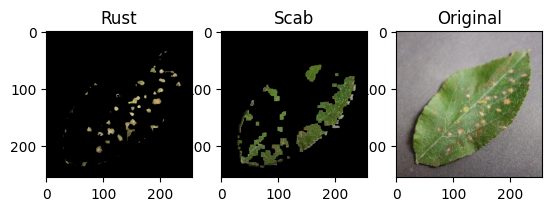

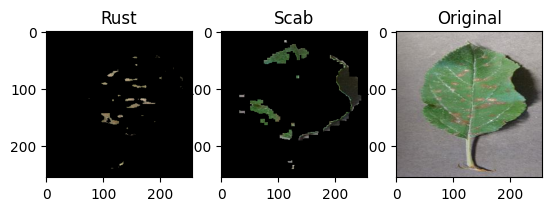

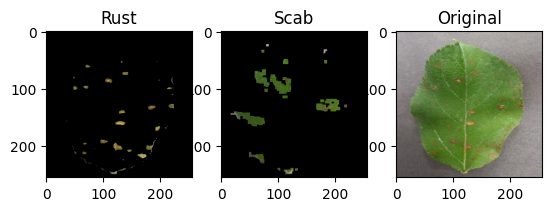

In [8]:
for i in range (530,533,1): #581 y 584
    org_image = cv2.imread(PATH + str(i) + ".jpg", cv2.IMREAD_COLOR)
    disease_segmented_1=mask_rust_healthy(org_image)
    disease_segmented_2=mask_scab(org_image)
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(disease_segmented_1, cv2.COLOR_BGR2RGB))
    plt.title('Rust')
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(disease_segmented_2, cv2.COLOR_BGR2RGB))
    plt.title('Scab')
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.show()
    

Feature extraction

Definición de conversiones en espacios de color

In [14]:
from PIL import Image

def rgb2cmyk(image):
    # Convertir la imagen de CV2 a PIL
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Convertir la imagen RGB a modo CMYK
    cmyk_image = image_pil.convert('CMYK')
    image_np = np.array(cmyk_image)
    # Convertir la imagen de matriz NumPy a formato CV2
    cmyk_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return cmyk_image

def rgb2hsi(image):
    # Normalizar los canales de color a valores entre 0 y 1
    image_norm = image.astype(np.float32) / 255.0

    # Separar los canales de color
    red = image_norm[:, :, 2]
    green = image_norm[:, :, 1]
    blue = image_norm[:, :, 0]

    # Calcular el componente de intensidad
    intensity = np.mean(image_norm, axis=2)

    # Calcular el componente de saturación
    min_channel = np.minimum(np.minimum(red, green), blue)
    saturation = 1.0 - 3.0 * min_channel / (red + green + blue + 1e-7)

    # Calcular el componente de matiz
    numerator = 0.5 * ((red - green) + (red - blue))
    denominator = np.sqrt((red - green)**2 + (red - blue) * (green - blue))
    hue = np.arccos(numerator / (denominator + 1e-7))
    hue[np.isnan(hue)] = 0.0
    hue[blue > green] = 2.0 * np.pi - hue[blue > green]
    hue = hue / (2.0 * np.pi)

    # Combinar los componentes de HSI en una imagen
    hsi_image = np.stack([hue, saturation, intensity], axis=2)

    return hsi_image



In [23]:
def extract_color_features(image):
    # RGB
    rgb_histogram = np.histogram(image, bins=256, range=(0, 255), density=True)[0]
    rgb_moments = np.mean(image), np.std(image)

    # Lab
    lab_image = rgb2lab(image)
    lab_histogram = np.histogram(lab_image, bins=256, range=(-128, 127), density=True)[0]
    lab_moments = np.mean(lab_image), np.std(lab_image)

    # CMYK
    cmyk_image = rgb2cmyk(image)
    cmyk_histogram = np.histogram(cmyk_image, bins=256, range=(0, 1), density=True)[0]
    cmyk_moments = np.mean(cmyk_image), np.std(cmyk_image)

    # HSI
    hsi_image = rgb2hsi(image)
    hsi_histogram = np.histogram(hsi_image, bins=256, range=(0, 1), density=True)[0]
    hsi_moments = np.mean(hsi_image), np.std(hsi_image)

    # HSV
    hsv_image = rgb2hsv(image)
    hsv_histogram = np.histogram(hsv_image, bins=256, range=(0, 1), density=True)[0]
    hsv_moments = np.mean(hsv_image), np.std(hsv_image)

    # YCrCb
    ycbcr_image = rgb2ycbcr(image)
    ycbcr_histogram = np.histogram(ycbcr_image, bins=256, range=(0, 255), density=True)[0]
    ycbcr_moments = np.mean(ycbcr_image), np.std(ycbcr_image)


    # Texture descriptors (GLCM)
    gray_image = img_as_ubyte(color.rgb2gray(image))
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return {
        'rgb_moments': rgb_moments,
        #'rgb_histogram': rgb_histogram,
        #'lab_histogram': lab_histogram,
        'lab_moments': lab_moments,
        #'cmyk_histogram': cmyk_histogram,
        'cmyk_moments': cmyk_moments,
        #'hsi_histogram': hsi_histogram,
        'hsi_moments': hsi_moments,
        'hsv_moments': hsv_moments,
        #'hsv_histogram': hsv_histogram,
        'ycbcr_moments': ycbcr_moments,
        #'ycbcr_histogram': ycbcr_histogram,
        'contrast': contrast,
        'correlation': correlation,
        'energy': energy,
        'homogeneity': homogeneity
    }

features = extract_color_features(org_image)
print(features)

# Arreglo para extracción de las características
def features2array (features):
    Extracted_features = []
    for k,v in features.items():
        if type(v)==tuple:
            for vv in v:
                Extracted_features.append(vv)
        else:
            Extracted_features.append(v)
    #print (Extracted_features)
    return Extracted_features


extracted_features = features2array (features)
print (extracted_features)

{'rgb_moments': (114.62761942545573, 39.76334039853082), 'lab_moments': (13.659745218963648, 30.88744305909009), 'cmyk_moments': (140.37238057454428, 39.76334039853082), 'hsi_moments': (0.3047227, 0.22790046), 'hsv_moments': (0.45916806669102267, 0.20424282798609392), 'ycbcr_moments': (119.34620066843466, 18.418749997595448), 'contrast': 46.28751531862745, 'correlation': 0.9710513920650037, 'energy': 0.02487768915372441, 'homogeneity': 0.2660515028779102}
[114.62761942545573, 39.76334039853082, 13.659745218963648, 30.88744305909009, 140.37238057454428, 39.76334039853082, 0.3047227, 0.22790046, 0.45916806669102267, 0.20424282798609392, 119.34620066843466, 18.418749997595448, 46.28751531862745, 0.9710513920650037, 0.02487768915372441, 0.2660515028779102]


c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
